## Implementación de un modelo de deep learning

In [1]:
# Import libraries 
import os
import numpy as np

# Visualize images
import matplotlib.pyplot as plt

# Separate folders into train, test and valid
import splitfolders

# Manage images
import PIL
from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError

# Everything related to the model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy

# Check if i'm using gpu
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
folder ="Animals"
count = 0

# Rename the dataset images
for fol in os.listdir(folder):
    for f in os.listdir(folder+"/"+fol):
        old_name = f"{folder}/{fol}/{f}"
        new_name = f"{folder}/{fol}/{fol}{count}.jpg"
        os.rename(old_name, new_name)
        count += 1
    count = 0


In [3]:
# Split into train and test
splitfolders.ratio(folder,                # The location of dataset
                   output="Animals_new", # The output location
                   seed=42,               # The number of seed
                   ratio=(.7, .2, .1),    # The ratio of splited dataset
                   group_prefix=None,     # Dataset contains more than one kind of file like ".jpg", ".pdf", etc.
                )

Copying files: 170 files [00:01, 152.20 files/s]


In [4]:
# Delete some corrupted images that i found
print("Corrupted images in train")
path = Path("Animals_new/train").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

print("Corrupted images in val")
path = Path("Animals_new/val").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

print("Corrupted images in test")
path = Path("Animals_new/test").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

Corrupted images in train
Corrupted images in val
Corrupted images in test


In [7]:
# Create directorio for train, test and valid
base_dir = 'Animals_new'

test_dir = base_dir + '/' + 'test'
train_dir = base_dir + '/' + 'train'
validation_dir = base_dir + '/' + 'val'

In [8]:
# Normalize images and add augmentation
train_data = ImageDataGenerator(rescale=1./255,
								rotation_range=40,
								width_shift_range=0.3,
								height_shift_range=0.2,
								shear_range=0.2,
								zoom_range=0.25,
								horizontal_flip=True)

val_data = ImageDataGenerator(rescale=1./255)

# Get out train and valid ready to make our model
train_generator = train_data.flow_from_directory(
							train_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

val_generator = val_data.flow_from_directory(
							validation_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

Found 117 images belonging to 5 classes.
Found 32 images belonging to 5 classes.


# First Model

In [9]:
# Use transfer learning with vgg16
vgg_model = VGG16(weights='imagenet',
                include_top = False,
                input_shape=(220, 220, 3))

# Get every but the last layer from vgg16 
model = models.Sequential()
model.add(vgg_model)
# Add new layers to train our dataset
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# Freeze vgg16 layer to not-retrain
vgg_model.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,154,949
Trainable params: 9,440,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['acc'])


In [12]:
history = model.fit(train_generator, epochs=30,
				validation_data=val_generator)

Epoch 1/30
8/8 [==============================] - 6s 801ms/step - loss: 2.7778 - acc: 0.3675 - val_loss: 1.0623 - val_acc: 0.6562
Epoch 2/30
8/8 [==============================] - 6s 785ms/step - loss: 1.7497 - acc: 0.5043 - val_loss: 1.7393 - val_acc: 0.6250
Epoch 3/30
8/8 [==============================] - 6s 801ms/step - loss: 1.6323 - acc: 0.5641 - val_loss: 0.7619 - val_acc: 0.6875
Epoch 4/30
8/8 [==============================] - 7s 826ms/step - loss: 0.9732 - acc: 0.6325 - val_loss: 1.6420 - val_acc: 0.5312
Epoch 5/30
8/8 [==============================] - 7s 823ms/step - loss: 1.1412 - acc: 0.6410 - val_loss: 1.0144 - val_acc: 0.6562
Epoch 6/30
8/8 [==============================] - 7s 820ms/step - loss: 0.7002 - acc: 0.7436 - val_loss: 0.9408 - val_acc: 0.6875
Epoch 7/30
8/8 [==============================] - 7s 825ms/step - loss: 0.7833 - acc: 0.7179 - val_loss: 0.8387 - val_acc: 0.6562
Epoch 8/30
8/8 [==============================] - 7s 839ms/step - loss: 0.6836 - acc: 0.71

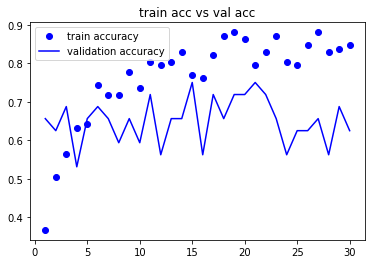

In [13]:
model.save('animals.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()


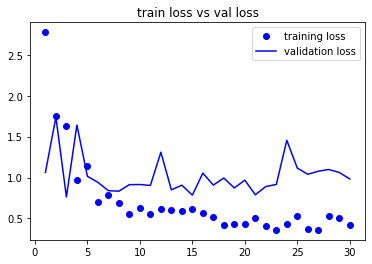

In [14]:
plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()


 # Second Model

In [19]:
# Use transfer learning with vgg16
vgg_model = VGG16(weights='imagenet',
                include_top = False,
                input_shape=(220, 220, 3))

# Get every but the last layer from vgg16 
model2 = models.Sequential()
model2.add(vgg_model)
# Add new layers to train our dataset
model2.add(layers.Flatten())
model2.add(layers.Dense(5, activation='softmax'))

# Freeze vgg16 layer to not-retrain
vgg_model.trainable = False

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 92165     
                                                                 
Total params: 14,806,853
Trainable params: 92,165
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
# Compile the model with our configurations
model2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss=losses.categorical_crossentropy,
             metrics=['acc'])


In [22]:
history = model2.fit(train_generator, epochs=30,
				validation_data=val_generator)


Epoch 1/30
8/8 [==============================] - 7s 892ms/step - loss: 2.0876 - acc: 0.2308 - val_loss: 1.6961 - val_acc: 0.2812
Epoch 2/30
8/8 [==============================] - 6s 800ms/step - loss: 1.3920 - acc: 0.4359 - val_loss: 1.1073 - val_acc: 0.4688
Epoch 3/30
8/8 [==============================] - 6s 803ms/step - loss: 1.0117 - acc: 0.6154 - val_loss: 1.0483 - val_acc: 0.6250
Epoch 4/30
8/8 [==============================] - 7s 828ms/step - loss: 1.0828 - acc: 0.5812 - val_loss: 0.9143 - val_acc: 0.6875
Epoch 5/30
8/8 [==============================] - 6s 864ms/step - loss: 0.8530 - acc: 0.6752 - val_loss: 0.7794 - val_acc: 0.6250
Epoch 6/30
8/8 [==============================] - 6s 771ms/step - loss: 0.8115 - acc: 0.6838 - val_loss: 0.7773 - val_acc: 0.7500
Epoch 7/30
8/8 [==============================] - 6s 773ms/step - loss: 0.8162 - acc: 0.6581 - val_loss: 0.9224 - val_acc: 0.6562
Epoch 8/30
8/8 [==============================] - 6s 803ms/step - loss: 0.9648 - acc: 0.60

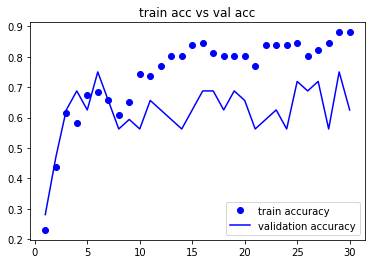

In [23]:
model2.save('animals2.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()


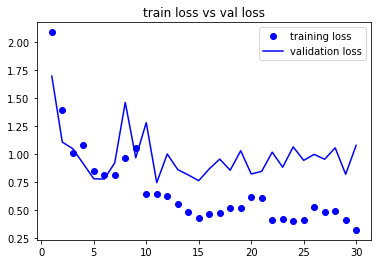

In [24]:
plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

## Model 1 vs Model 2

In [25]:
# Loads the models
model = models.load_model("animals.h5")
model2 = models.load_model("animals2.h5")

test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size=(220, 220),
					batch_size=32,
					class_mode='categorical')

# Test the fist model
test_loss, test_acc = model.evaluate(test_generator, steps=25)
print('\ntest acc :\n', test_acc)
print("-------------------------------------------------------")
# Test the second model
test_loss, test_acc = model2.evaluate(test_generator, steps=25)
print('\ntest acc :\n', test_acc)

Found 21 images belonging to 5 classes.


c:\Users\Edu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


25/25 [==============================] - 1s 458us/step - loss: 51.3928 - acc: 0.6667

test acc :
 0.6666666865348816
-------------------------------------------------------
25/25 [==============================] - 1s 417us/step - loss: 56.4727 - acc: 0.5714

test acc :
 0.5714285969734192


In [33]:
# Modelo entrenado con todo nuestro dataset
best_model = models.load_model("animals.h5")

# Getting the class names
base_dir = 'Animals_new'
train_dir = base_dir + '/' + 'train'

class_names = os.listdir(train_dir)
labels = {}
for i in range(len(class_names)):
    labels[i] = class_names[i]
print(labels)


{0: 'Cheetah', 1: 'Jaguar', 2: 'Leopard', 3: 'Lion', 4: 'Tiger'}


1/1 [==============================] - 0s 73ms/step


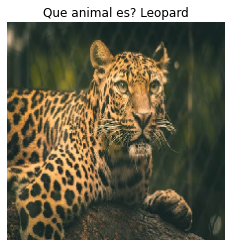

In [35]:
image = load_img(r'C:\Users\Edu\Desktop\avance\Animals_new\test\Leopard\Leopard11.jpg', target_size=(220, 220))


img = np.array(image)
img = img / 255.0
img = img.reshape(1,220,220,3)

label = best_model.predict(img)

index = np.argmax(label)
plt.imshow(image)
plt.axis("off")

plt.title("Que animal es? %s" %(labels[index]));